In [1]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import plotly.express as px
from data_cleaning import data_cleaning
from data_loader import resnet_traditional_model
import PIL

test_size = 0.15
seed = 9
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [2]:
data_cleaning(False, True)

[STATUS] copying pics in data_set\self-collected\002_0_tohsaka_rin_official to data_set\modeling_data\tohsaka_rin
[STATUS] 002_0_tohsaka_rin_official copy work finished
[STATUS] copying pics in data_set\self-collected\003_0_mato_sakura_official to data_set\modeling_data\mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set\self-collected\004_0_illyasviel_von_einzbern_official to data_set\modeling_data\illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\modeling_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\modeling_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\modeling_data\vi

In [3]:
warnings.filterwarnings('ignore')
loader = resnet_traditional_model()
loader.write_data()

[STATUS] Extract img color mean and std illyasviel_von_einzbern
[STATUS] Extract img color mean and std mato_sakura
[STATUS] Extract img color mean and std misaka_mikoto
[STATUS] Extract img color mean and std rider_medusa
[STATUS] Extract img color mean and std saber_arutoria_pendoragon
[STATUS] Extract img color mean and std tohsaka_rin
[STATUS] Extract img color mean and std violet_evergarden
[STATUS] Using device: cuda:0
[STATUS] 1/7 Processing illyasviel_von_einzbern
[STATUS] 2/7 Processing mato_sakura
[STATUS] 3/7 Processing misaka_mikoto
[STATUS] 4/7 Processing rider_medusa
[STATUS] 5/7 Processing saber_arutoria_pendoragon
[STATUS] 6/7 Processing tohsaka_rin
[STATUS] 7/7 Processing violet_evergarden
[STATUS] Feature extraction complete in 0m 19s
[STATUS] feature vector shape: (791, 1000)
[STATUS] label vector shape: (791,)
[STATUS] training labels encoded.
[STATUS] save to data_set\resnet_img_feature.mat


### load saved data

In [4]:
data = sio.loadmat(os.path.join('data_set', 'resnet_img_feature.mat'))

### normalize data

In [5]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['resnet_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [6]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (672, 1000)
Test data    : (119, 1000)
Train labels : (672,)
Test labels  : (119,)


## Hyper parameter Tuning

### Logistic Regression:

1. Penalty Function

2. C

In [7]:
MAX_ITER = 10000 # tunned, no change after 100
TOL = 1e-4 # tunned, no change
C = 1.1 # tunned

In [8]:
# Penalty Function
list_p = ["l2", "none"]
list_c = np.linspace(1.5, 2.4, 10)

p_models = dict()

for i in list_p:
    p_models[i] = dict()
    for c in list_c:
        p_models[i][c] =  LogisticRegression(penalty=i, max_iter=MAX_ITER, random_state=seed,
                                             tol=TOL, C=c, warm_start=True)

p_results = {'l2': [], "none": []}
p_names = {'l2': [], "none": []}

for penalty in p_models:
    for name, model in p_models[penalty].items():
        since = time.time()
        kf = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        p_results[penalty].append(cv_results)
        p_names[penalty].append(name)
        print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name,
                                                                                     cv_results.mean(),
                                                                                     cv_results.std()))
        time_elapsed = time.time() - since
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                                       time_elapsed % 60))

[CROSS_VAL_SCORE] Training 1.5 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 1.6 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 1.7 : accuracy: 0.912, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 1.8 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 1.9 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 2.0 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 2.1 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 2.2 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 2.3 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 2.4 : accuracy: 0.914, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL

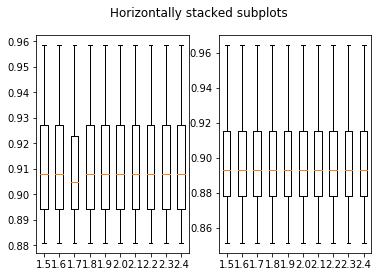

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.boxplot(p_results['l2'])
ax1.set_xticklabels(p_names['l2'])
ax2.boxplot(p_results['none'])
ax2.set_xticklabels(p_names['none'])
plt.show()

In [12]:
list_i = np.linspace(.1, 10., 100)

c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
            for i in np.linspace(.1, 10, 100)}

results = []
names = []

for name in c_models:
    since = time.time()
    model = c_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training 0.1 : accuracy: 0.914, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.2 : accuracy: 0.915, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.30000000000000004 : accuracy: 0.915, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.4 : accuracy: 0.915, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.5 : accuracy: 0.914, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.6 : accuracy: 0.915, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.7000000000000001 : accuracy: 0.914, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.8 : accuracy: 0.912, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.9 : accuracy: 0.915, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.914, std: 0.028
[TIME_CONSUMPTION

[CROSS_VAL_SCORE] Training 8.1 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.2 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.3 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.4 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.5 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.6 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.7 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.8 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 8.9 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 9.0 : accuracy: 0.908, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL

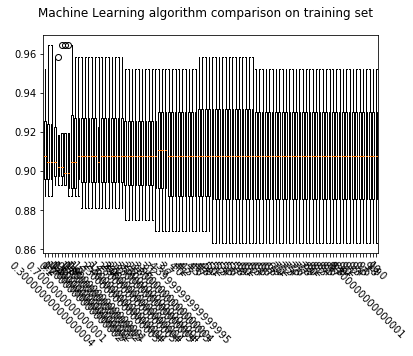

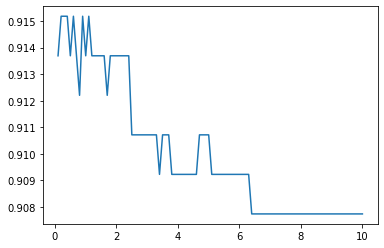

In [13]:
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
plt.show()

### KNN hyperparam tunning

K = 8

In [14]:
list_i = range(1, 30)

k_models = {k: KNeighborsClassifier(n_neighbors=k) for k in list_i}

results = []
names = []

for name in k_models:
    since = time.time()
    model = k_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

[CROSS_VAL_SCORE] Training 1 : accuracy: 0.778, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2 : accuracy: 0.763, std: 0.009
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 3 : accuracy: 0.790, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 4 : accuracy: 0.812, std: 0.037
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 5 : accuracy: 0.826, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 6 : accuracy: 0.821, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 7 : accuracy: 0.821, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8 : accuracy: 0.829, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 9 : accuracy: 0.826, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 10 : accuracy: 0.821, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 11

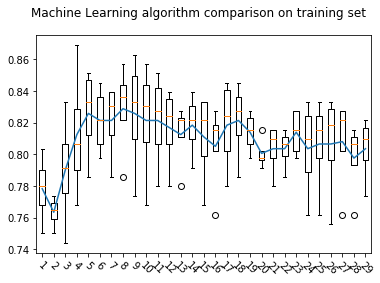

In [15]:
# def plot_hypertune(params, model_names, scores):
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
plt.show()

### Random Forest

1. Error function
2. n_estimators

In [16]:
rf_gini_acc = []
rf_gini_time_list = []
rf_entropy_acc = []
rf_entropy_time_list = []
rf_loss_f_n_list = np.hstack([np.array([10,50,100,500]),np.linspace(600,1500,num=5)])
for n in rf_loss_f_n_list:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training gini, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_gini_time_list.append(time_elapsed)
    rf_gini_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training entropy, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_entropy_time_list.append(time_elapsed)
    rf_entropy_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training gini, n_estimators: 10.0, accuracy: 0.704, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 10.0, accuracy: 0.699, std: 0.009
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 50.0, accuracy: 0.830, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 50.0, accuracy: 0.826, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training gini, n_estimators: 100.0, accuracy: 0.829, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 100.0, accuracy: 0.824, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training gini, n_estimators: 500.0, accuracy: 0.848, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 11s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 500.0, accuracy: 0.842, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 26s
[CROSS_VAL_SCORE] Training gin

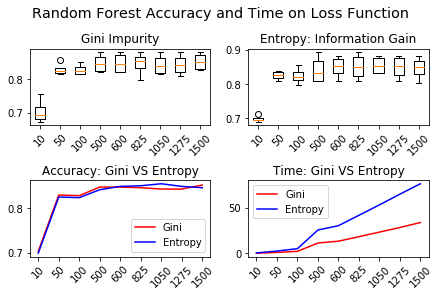

In [17]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 2)
fig.suptitle('Random Forest Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0:3,0])
plt.boxplot(rf_gini_acc)
ax1.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Gini Impurity')
plt.xticks(rotation=45, horizontalalignment="center")

ax2 = fig.add_subplot(gs[0:3,1 ])
plt.boxplot(rf_entropy_acc)
ax2.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Entropy: Information Gain')
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,0])
plt.title('Accuracy: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_gini_acc], c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_entropy_acc], c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,1])
plt.title('Time: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_gini_time_list, c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_entropy_time_list, c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
plt.show()

In [18]:
acc = []
time_list = []
n_list_2 = np.hstack([np.array([10,50,100,500]),np.linspace(600,1400,num=5),np.array([3000,5000])])
for n in n_list_2:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training n_estimators: {} : accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    time_list.append(time_elapsed)
    acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


[CROSS_VAL_SCORE] Training n_estimators: 10.0 : accuracy: 0.695, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training n_estimators: 50.0 : accuracy: 0.818, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training n_estimators: 100.0 : accuracy: 0.838, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training n_estimators: 500.0 : accuracy: 0.841, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 25s
[CROSS_VAL_SCORE] Training n_estimators: 600.0 : accuracy: 0.847, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 31s
[CROSS_VAL_SCORE] Training n_estimators: 800.0 : accuracy: 0.850, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 41s
[CROSS_VAL_SCORE] Training n_estimators: 1000.0 : accuracy: 0.850, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 51s
[CROSS_VAL_SCORE] Training n_estimators: 1200.0 : accuracy: 0.850, std: 0.021
[TIME_CONSUMPTION] Finishing in 1m 1s
[CROSS_VAL_SCORE] Training n_estimators: 1400.0 : accuracy: 0.850, std: 0.02

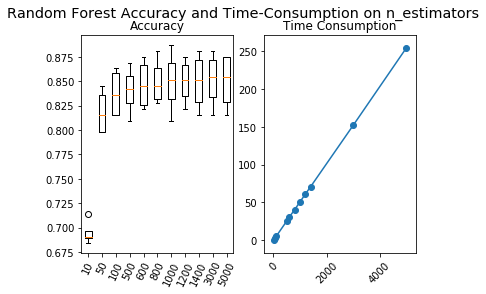

In [20]:
fig = plt.figure()
fig.suptitle("Random Forest Accuracy and Time-Consumption on n_estimators", fontsize='x-large')
ax = fig.add_subplot(121)
plt.boxplot(acc)
ax.set_xticklabels([int(x) for x in n_list_2])
plt.xticks(rotation=65, horizontalalignment="center")
plt.title('Accuracy')
ax = fig.add_subplot(1,2,2)
ax.plot([int(x) for x in n_list_2], time_list)
ax.scatter([int(x) for x in n_list_2], time_list)
plt.xticks(rotation=45, horizontalalignment="center")
plt.title('Time Consumption')
plt.show()

### SVM
1. Loss Function
2. C
3. poly degree

In [21]:
svm_ker_acc = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_time_list = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_n_list = np.hstack([np.linspace(1,5,5),8,10,20,50,100])
for c in svm_ker_n_list:
    for ker in ["linear", "poly", 'rbf', 'sigmoid']:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel=ker, C=c, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(ker,c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_ker_time_list[ker].append(time_elapsed)
        svm_ker_acc[ker].append(cv_results)
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: linear, C = 1.0, accuracy: 0.911, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 1.0, accuracy: 0.923, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 1.0, accuracy: 0.902, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 1.0, accuracy: 0.205, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: linear, C = 2.0, accuracy: 0.911, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.923, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 2.0, accuracy: 0.909, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 2.0, accuracy: 0.205, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: linear, C = 3.0, accuracy: 0.

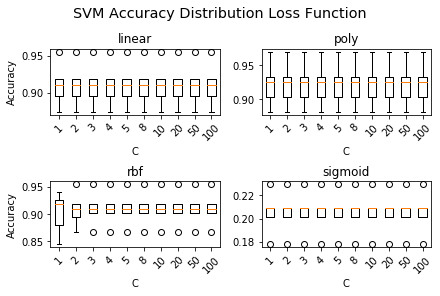

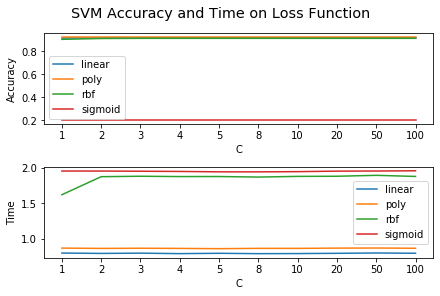

In [22]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
fig.suptitle('SVM Accuracy Distribution Loss Function', fontsize='x-large')

for i, key in enumerate(svm_ker_acc.keys()):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    plt.boxplot(svm_ker_acc[key])
    ax.set_xticklabels([int(x) for x in svm_ker_n_list])
    if i%2 == 0:
        plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.title(key)
    plt.xticks(rotation=45, horizontalalignment="center")

plt.show()



fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2)
fig.suptitle('SVM Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax1.plot([str(int(x)) for x in svm_ker_n_list], [x.mean() for x in svm_ker_acc[key]], label=key)
plt.ylabel('Accuracy')
plt.xlabel('C')
ax1.legend()

ax2 = fig.add_subplot(gs[1,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax2.plot([str(int(x)) for x in svm_ker_n_list], svm_ker_time_list[key], label=key)
plt.ylabel('Time')
plt.xlabel('C')
ax2.legend()
plt.show()

## Use poly

In [24]:
# C of poly
# degree for poly
svm_c_list = np.linspace(1,5,5)
svm_degree_list = range(1,21)
svm_shape = (len(svm_c_list), len(svm_degree_list))
svm_acc = pd.DataFrame(np.zeros(svm_shape))
svm_acc.columns = svm_degree_list
svm_acc.index = svm_c_list
svm_time = pd.DataFrame(np.zeros(svm_shape))
svm_time.columns = svm_degree_list
svm_time.index = svm_c_list

for degree in svm_degree_list:
    for c in svm_c_list:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel='poly', C=c, degree=degree, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: poly,degree = {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(degree, c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_acc.loc[c, degree] = cv_results.mean()
        svm_time.loc[c, degree] = time_elapsed
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 1.0, accuracy: 0.908, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 2.0, accuracy: 0.917, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 3.0, accuracy: 0.921, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 4.0, accuracy: 0.923, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 5.0, accuracy: 0.921, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 1.0, accuracy: 0.920, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 2.0, accuracy: 0.920, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 3.0, accuracy: 0.920, std: 0.024
[TIME_CONSUMPTION] Fin

[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 1.0, accuracy: 0.909, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 2.0, accuracy: 0.909, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 3.0, accuracy: 0.909, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 4.0, accuracy: 0.909, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 5.0, accuracy: 0.909, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 15, C = 1.0, accuracy: 0.908, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 15, C = 2.0, accuracy: 0.908, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 15, C = 3.0, accuracy: 0.908, std: 0.025
[TIME_CONSUMPT

In [25]:
x_acc = []
y_acc = []
z_acc = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_acc.append(degree)
        y_acc.append(c)
        z_acc.append(svm_acc.loc[c, degree])
# z_acc_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_acc)))
x_time = []
y_time = []
z_time = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_time.append(degree)
        y_time.append(c)
        z_time.append(svm_time.loc[c, degree])
# z_time_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_time)))

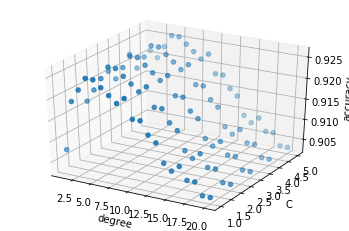

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_acc, y_acc, z_acc, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('accuracy')
plt.show()

In [27]:
df_acc = pd.DataFrame({
    'degree': x_acc,
    'C': y_acc,
    'accuracy': z_acc
})
fig = px.scatter_3d(df_acc, x='degree', y='C', z='accuracy', color='accuracy', size='accuracy', size_max=13)
fig.show()

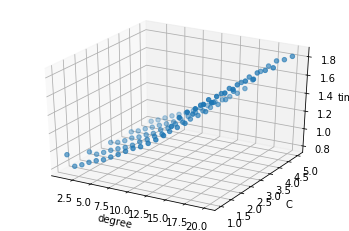

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_time, y_time, z_time, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('time')
plt.show()

In [29]:
df_time = pd.DataFrame({
    'degree': x_time,
    'C': y_time,
    'time': z_time
})
fig = px.scatter_3d(df_time, x='degree', y='C', z='time', color='time', size_max=13)
fig.show()

In [34]:
i = np.array(z_acc).argmax()
svm_c = y_acc[i]
svm_degree = x_acc[i]
print("C = {}, degree = {}".format(svm_c, svm_degree))

[0.9078054173576561, 0.9167053620784964, 0.9211940298507463, 0.9226755113322278, 0.921182974018795, 0.9196904367053621, 0.9196904367053621, 0.9196904367053621, 0.9196904367053621, 0.9196904367053621, 0.9226755113322278, 0.9226755113322278, 0.9226755113322278, 0.9226755113322278, 0.9226755113322278, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9256495301271421, 0.9241680486456607, 0.9241680486456607, 0.9241680486456607, 0.9241680486456607, 0.9241680486456607, 0.9226976229961306, 0.9226976229961306, 0.9226976229961306, 0.9226976229961306, 0.9226976229961306, 0.9212050856826977, 0.9212050856826977, 0.9212050856826977, 0.9212050856826977, 0.9212050856826977, 0.9226865671641791, 0.9226865671641791, 0.9226865671641791, 0.9226865671641791, 0.9226865671641791, 0.9182421227197347, 0.9182421227197347, 0.9182421227197347, 0.9182421227197347, 0.9182421227197347, 

[CROSS_VAL_SCORE] Training LR : accuracy: 0.915, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.384, std: 0.059
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.829, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.546, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.845, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 41s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.811, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.917, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s


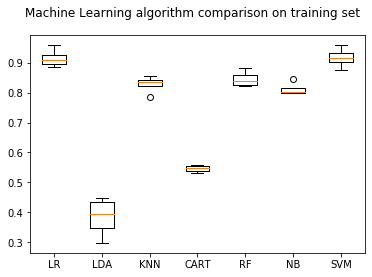

In [35]:
num_trees = 800
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=1.1, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = 8),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='entropy', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree, decision_function_shape='ovo')}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [37]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 1.000
[RESULT] LR accuracy on testing set: 0.941
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] LDA accuracy on training set: 1.000
[RESULT] LDA accuracy on testing set: 0.765
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] KNN accuracy on training set: 0.887
[RESULT] KNN accuracy on testing set: 0.832
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] CART accuracy on training set: 1.000
[RESULT] CART accuracy on testing set: 0.571
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] RF accuracy on training set: 1.000
[RESULT] RF accuracy on testing set: 0.891
[TIME_CONSUMPTION] Finishing in 0m 14s
[RESULT] NB accuracy on training set: 0.854
[RESULT] NB accuracy on testing set: 0.824
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] SVM accuracy on training set: 1.000
[RESULT] SVM accuracy on testing set: 0.908
[TIME_CONSUMPTION] Finishing in 0m 0s


### Best model: Random Froest
We build some examples using random forest model.

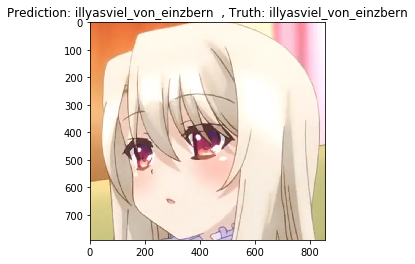

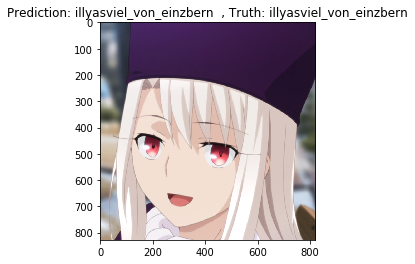

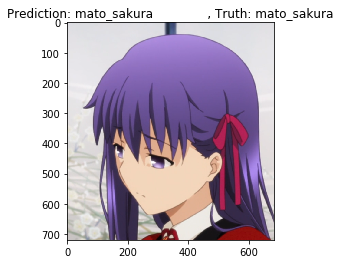

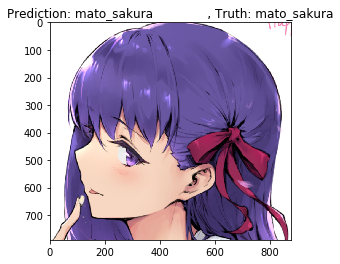

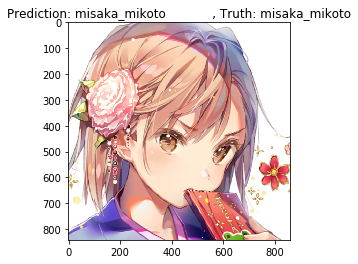

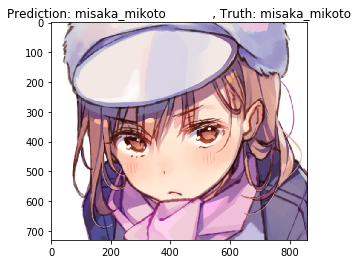

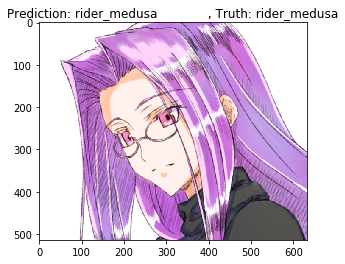

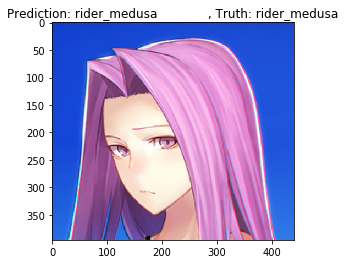

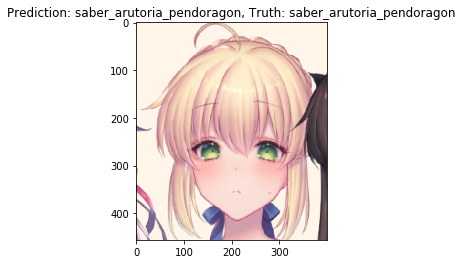

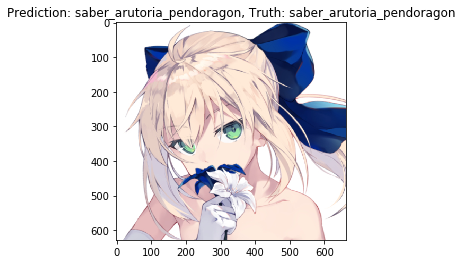

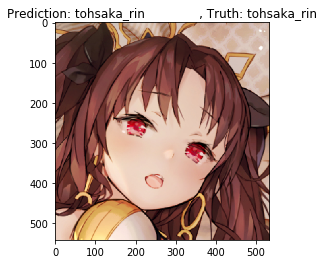

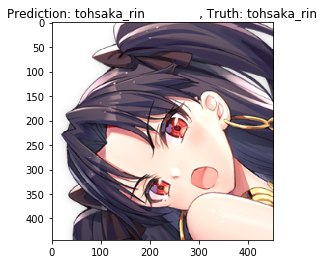

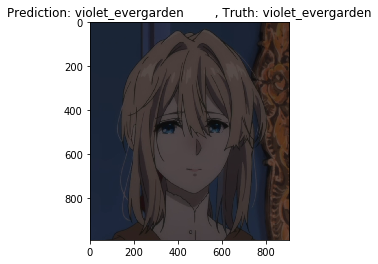

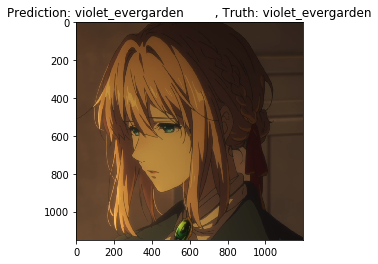

In [43]:
best_model = models['LR']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = PIL.Image.open(pic_dir).convert('RGB')
        pic_feature = loader.single_image_to_vec(image)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

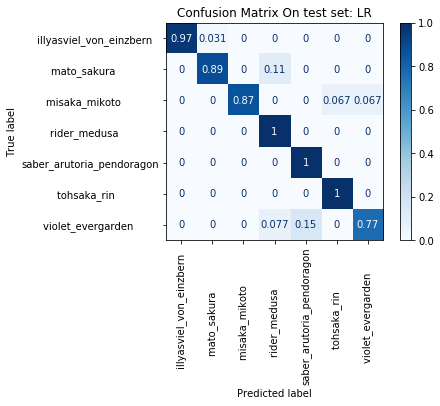

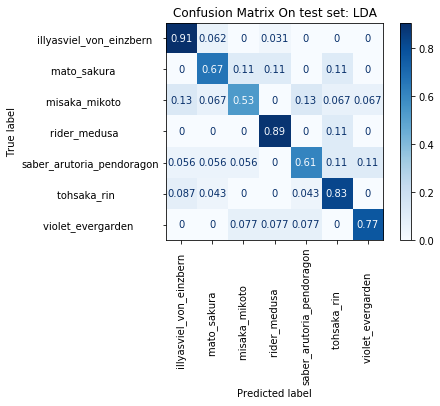

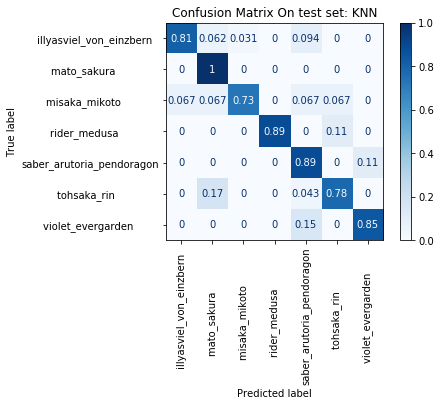

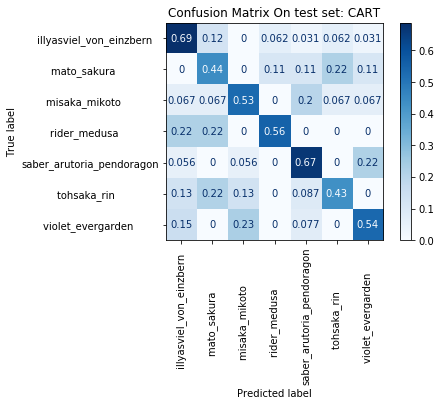

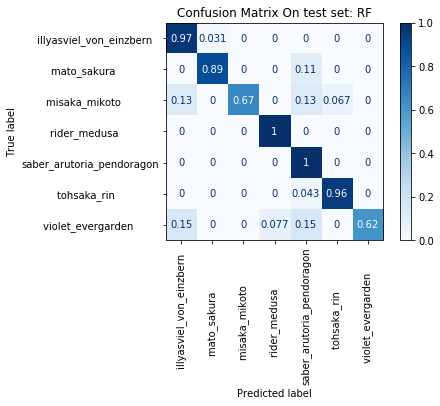

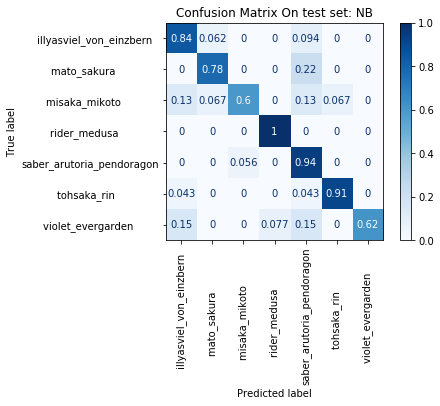

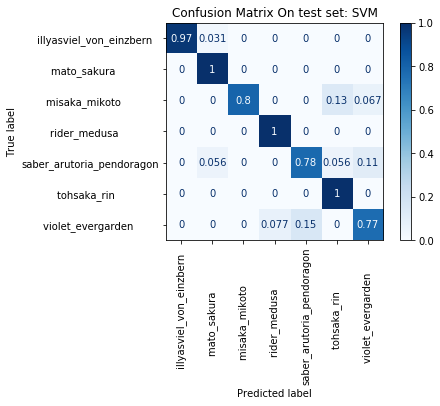

In [44]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()

In [45]:
print(loader.mean)
print(loader.std)

[0.6529833  0.56954163 0.55970765]
[0.29683845 0.29733288 0.28085221]


## Training on whole Dataset

### switching and reencode the dataset

In [2]:
data_cleaning(True, True)
loader = resnet_traditional_model()
loader.write_data()

[STATUS] copying pics in data_set\moeimouto-faces-filtered\000_hatsune_miku to data_set\modeling_data\hatsune_miku
[STATUS] 000_hatsune_miku copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\001_kinomoto_sakura to data_set\modeling_data\kinomoto_sakura
[STATUS] 001_kinomoto_sakura copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\002_suzumiya_haruhi to data_set\modeling_data\suzumiya_haruhi
[STATUS] 002_suzumiya_haruhi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\003_fate_testarossa to data_set\modeling_data\fate_testarossa
[STATUS] 003_fate_testarossa copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\004_takamachi_nanoha to data_set\modeling_data\takamachi_nanoha
[STATUS] 004_takamachi_nanoha copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\006_akiyama_mio to data_set\modeling_data\akiyama_mio
[STATUS] 006_akiyama_mio copy work finished
[STA

[STATUS] 054_horo copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\055_ibuki_fuuko to data_set\modeling_data\ibuki_fuuko
[STATUS] 055_ibuki_fuuko copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\056_nagi to data_set\modeling_data\nagi
[STATUS] 056_nagi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\058_kochiya_sanae to data_set\modeling_data\kochiya_sanae
[STATUS] 058_kochiya_sanae copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\059_sairenji_haruna to data_set\modeling_data\sairenji_haruna
[STATUS] 059_sairenji_haruna copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\060_ichinose_kotomi to data_set\modeling_data\ichinose_kotomi
[STATUS] 060_ichinose_kotomi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\061_furude_rika to data_set\modeling_data\furude_rika
[STATUS] 061_furude_rika copy work finished
[STATUS] cop

[STATUS] 123_midori copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\129_primula to data_set\modeling_data\primula
[STATUS] 129_primula copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\131_belldandy to data_set\modeling_data\belldandy
[STATUS] 131_belldandy copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\132_minamoto_chizuru to data_set\modeling_data\minamoto_chizuru
[STATUS] 132_minamoto_chizuru copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\134_nunnally_lamperouge to data_set\modeling_data\nunnally_lamperouge
[STATUS] 134_nunnally_lamperouge copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\136_shirley_fenette to data_set\modeling_data\shirley_fenette
[STATUS] 136_shirley_fenette copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\137_sonsaku_hakufu to data_set\modeling_data\sonsaku_hakufu
[STATUS] 137_sonsaku_hak

[STATUS] copying pics in data_set\self-collected\004_0_illyasviel_von_einzbern_official to data_set\modeling_data\illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\modeling_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\modeling_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\modeling_data\violet_evergarden
[STATUS] 007_0_violet_evergarden_official copy work finished
[STATUS] copying pics in data_set\self-collected\001_1_saber_arutoria_pendoragon_doujin to data_set\modeling_data\saber_arutoria_pendoragon
[STATUS] 001_1_saber_arutoria_pendoragon_doujin copy work finished
[STATUS] copying pics in data_set\self-collected\002_1

[STATUS] Extract img color mean and std saber_arutoria_pendoragon
[STATUS] Extract img color mean and std saigyouji_yuyuko
[STATUS] Extract img color mean and std sairenji_haruna
[STATUS] Extract img color mean and std sakagami_tomoyo
[STATUS] Extract img color mean and std sanzenin_nagi
[STATUS] Extract img color mean and std saotome_alto
[STATUS] Extract img color mean and std sendou_erika
[STATUS] Extract img color mean and std seto_san
[STATUS] Extract img color mean and std shameimaru_aya
[STATUS] Extract img color mean and std shana
[STATUS] Extract img color mean and std sheryl_nome
[STATUS] Extract img color mean and std shidou_hikaru
[STATUS] Extract img color mean and std shigure_asa
[STATUS] Extract img color mean and std shihou_matsuri
[STATUS] Extract img color mean and std shindou_chihiro
[STATUS] Extract img color mean and std shindou_kei
[STATUS] Extract img color mean and std shinku
[STATUS] Extract img color mean and std shirakawa_kotori
[STATUS] Extract img color mea

[STATUS] 141/162 Processing suigintou
[STATUS] 142/162 Processing suzumiya_akane
[STATUS] 143/162 Processing suzumiya_haruhi
[STATUS] 144/162 Processing suzumiya_haruka
[STATUS] 145/162 Processing tainaka_ritsu
[STATUS] 146/162 Processing takamachi_nanoha
[STATUS] 147/162 Processing takara_miyuki
[STATUS] 148/162 Processing takatsuki_yayoi
[STATUS] 149/162 Processing teana_lanster
[STATUS] 150/162 Processing tohsaka_rin
[STATUS] 151/162 Processing tsukimura_mayu
[STATUS] 152/162 Processing tsuruya
[STATUS] 153/162 Processing violet_evergarden
[STATUS] 154/162 Processing vita
[STATUS] 155/162 Processing vivio
[STATUS] 156/162 Processing yagami_hayate
[STATUS] 157/162 Processing yakumo_yukari
[STATUS] 158/162 Processing yoko
[STATUS] 159/162 Processing yoshida_kazumi
[STATUS] 160/162 Processing yuno
[STATUS] 161/162 Processing yuuki_mikan
[STATUS] 162/162 Processing yuzuhara_konomi
[STATUS] Feature extraction complete in 1m 54s
[STATUS] feature vector shape: (13799, 1000)
[STATUS] label 

### load data

In [3]:
data = sio.loadmat(os.path.join('data_set', 'resnet_img_feature.mat'))

### normalize data

In [4]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['resnet_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train Test Split

In [7]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (11729, 1000)
Test data    : (2070, 1000)
Train labels : (11729,)
Test labels  : (2070,)


In [9]:
# Logistic Regreession
lr_c = 1.1
# Knn
knn_k = 8
# rf
num_trees = 800
rf_loss_func='entropy'
# svm
svm_c = 1
svm_degree = 4

In [ ]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=lr_c, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = knn_k),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='gini', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree)}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))